In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

# !pip install -q torchsummary
# from torchsummary import summary

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

### 1. Load Colored MNIST dataset

In [3]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='train_SCM/data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='train_SCM/data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        self.T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            'img': self.T(ims),
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [4]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))
print(LABEL_SIZES)

60000 10000 4926
[10, 10, 10]


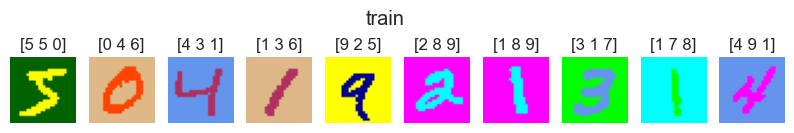

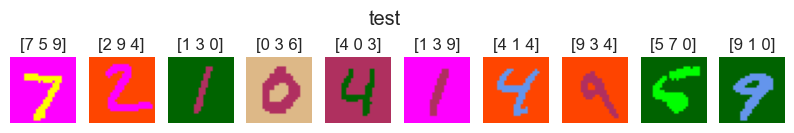

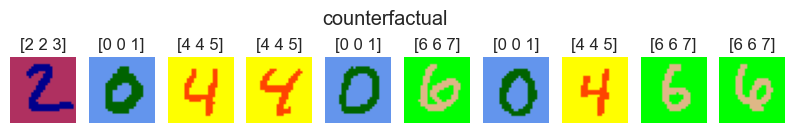

In [5]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [6]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

### 2. Build CVAE

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim=2, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3136 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3136 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=2, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=64*7*7)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.first_layer(x).view((-1, 64, 7, 7))
        return self.upsampling_layers(x)

In [12]:
class CVAE(nn.Module):
    def __init__(self, z_dim=2, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def get_one_hot(self, labels):
        new_ys = []
        for i, label_length in enumerate(LABEL_SIZES):
            new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
            new_ys.append(new_y)
        new_ys = torch.cat(new_ys, -1)
        return new_ys.to(torch.float32)

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, self.get_one_hot(labels)], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, self.get_one_hot(labels))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        z_loc, z_scale = self.encoder_(x, y_one_hot)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        loc_img = self.decoder_(torch.cat([z, y_one_hot], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 3. Train CVAE

### 3.1 CVAE Sanity Checks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pyro.clear_param_store()
vae = CVAE(z_dim=10, label_dim=30, p=0.1, use_cuda=USE_CUDA)
vae.load_state_dict(torch.load('/content/vae_05_02_exp44.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae.train(False);

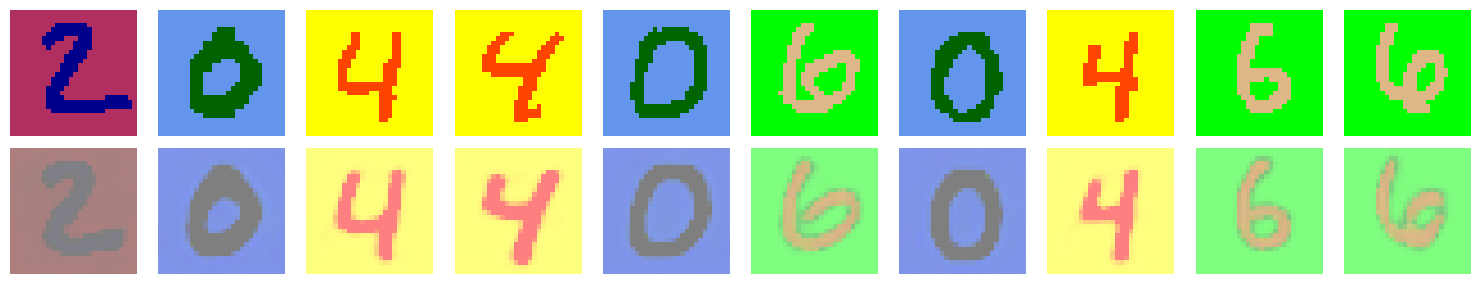

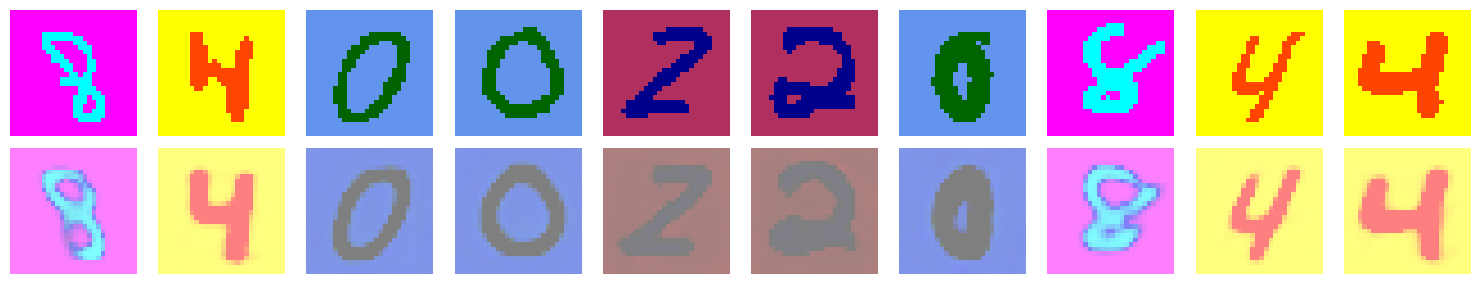

In [ ]:
show_reconstructions(vae, cf_loader, 10, 2);

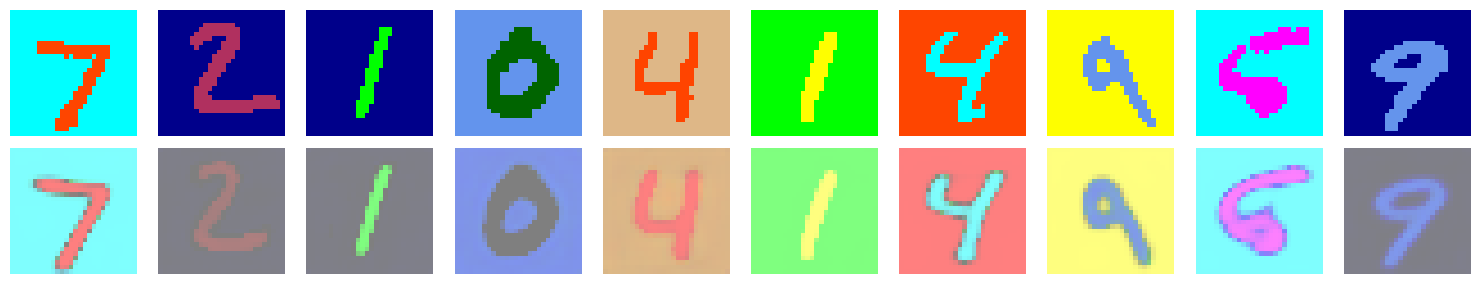

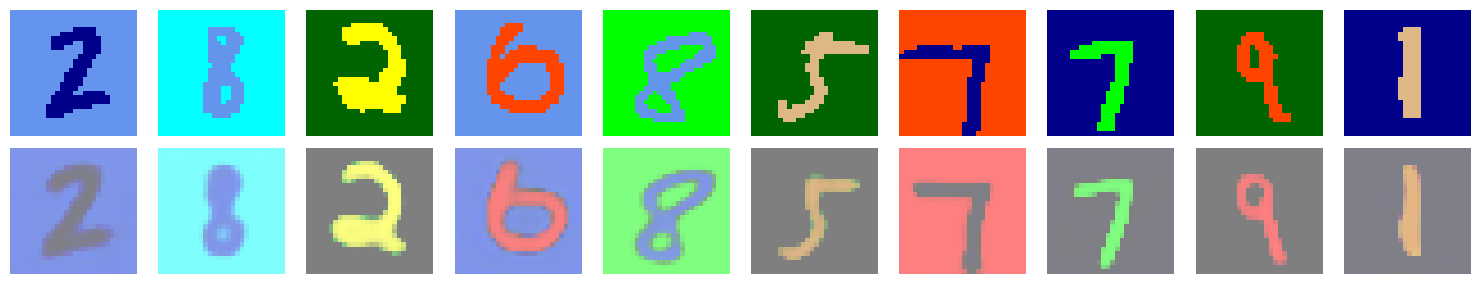

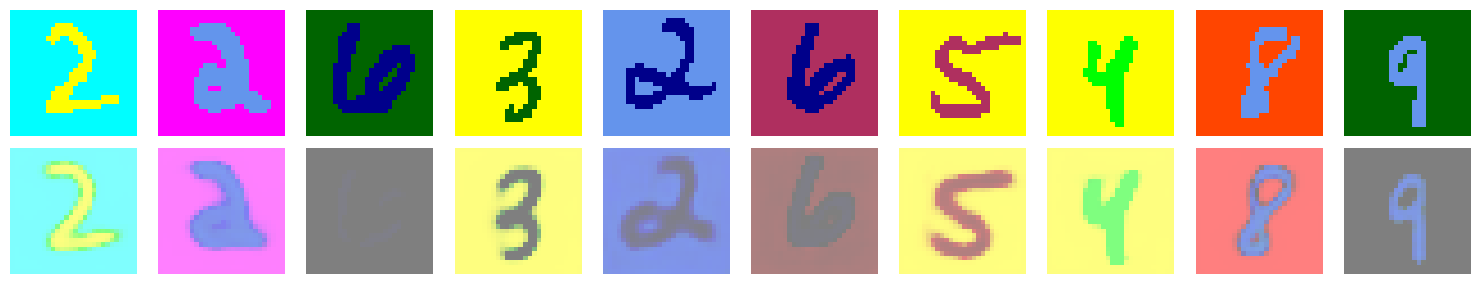

In [ ]:
show_reconstructions(vae, test_loader, 10, 3);

In [ ]:
def compare_imgs(im1, im2, title1, title2):
    f, ax = plt.subplots(1, 2, figsize=(3, 1.5))
    plot_img_on_ax(im1.permute(1,2,0), ax[0])
    ax[0].set_title(title1)
    plot_img_on_ax(im2.permute(1,2,0), ax[1])
    ax[1].set_title(title2)
    plt.show()

In [ ]:
def run_sanity_check_2(vae, test_loader):
    batch = next(iter(test_loader))
    idx = np.random.randint(0, len(batch['label']))
    x = batch['img'][idx:idx+1]
    l = batch['label'][idx:idx+1]
    mu, sigma = vae.encoder(x, l)
    B = 100
    zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for _ in range(B)], 0)
    ys = torch.cat([l for _ in range(B)], 0)
    rs = vae.decoder(zs, ys).detach() # 100, 3, 28, 28
    compare_imgs(x[0], rs.mean(0), l.tolist()[0], l.tolist()[0])

    print('Changing FG color')
    y_new = torch.tensor(l)
    f, ax = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, color_name in color_dict.items():
        y_new[0, 1] = i
        zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for _ in range(B)], 0)
        ys = torch.cat([y_new for _ in range(B)], 0)
        rs = vae.decoder(zs, ys).detach()
        plot_img_on_ax(rs.mean(0).permute(1,2,0), ax[i])
        ax[i].set_title(color_name)
    plt.show()

    print('Changing BG color')
    y_new = torch.tensor(l)
    f, ax = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, color_name in color_dict.items():
        y_new[0, 2] = i
        zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for _ in range(B)], 0)
        ys = torch.cat([y_new for _ in range(B)], 0)
        rs = vae.decoder(zs, ys).detach()
        plot_img_on_ax(rs.mean(0).permute(1,2,0), ax[i])
        ax[i].set_title(color_name)
    plt.show()

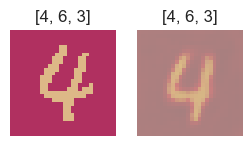

Changing FG color


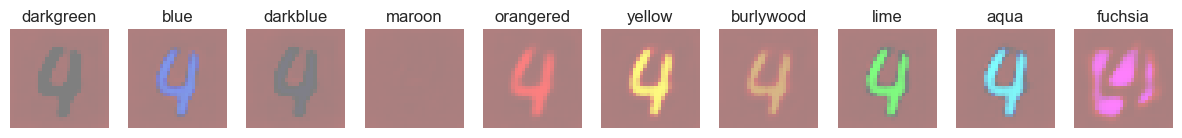

Changing BG color


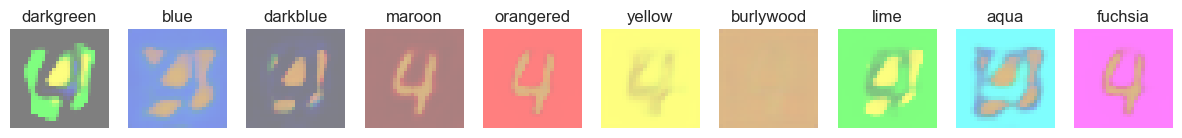

In [ ]:
run_sanity_check_2(vae, test_loader)

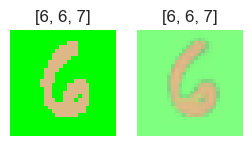

Changing FG color


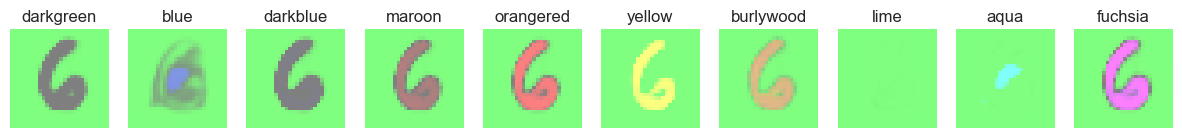

Changing BG color


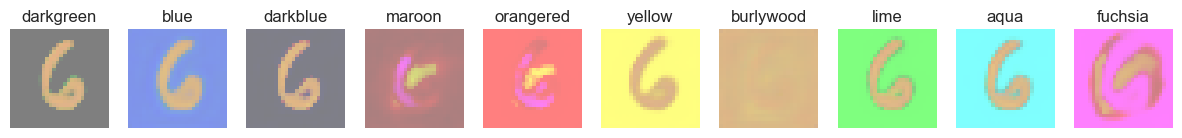

In [ ]:
run_sanity_check_2(vae, cf_loader)

### 6.2 SCM params

In [42]:
import pickle
with open('train_SCM/zdim=10_constrained/params_zdim10_constrained.pkl', "rb") as f:
    scm_params = pickle.load(f)

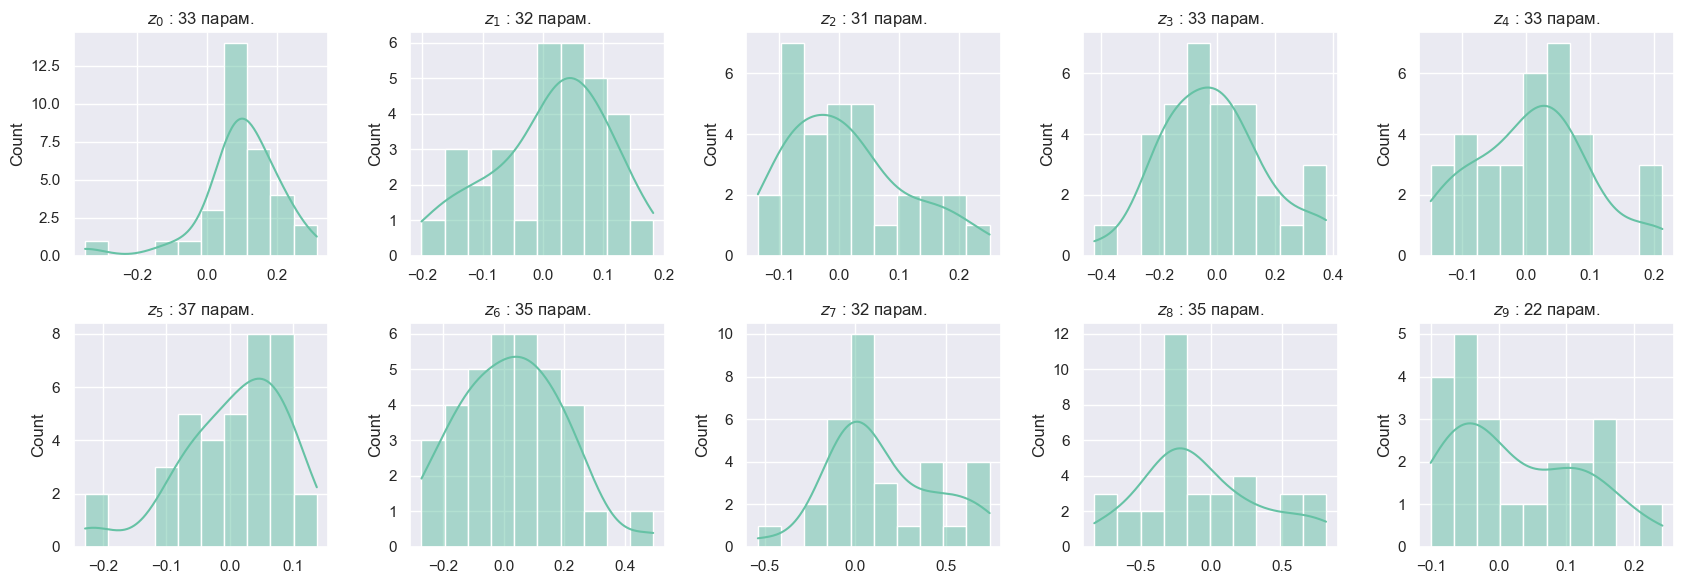

In [43]:
f, ax = plt.subplots(2, 5, figsize=(17, 6))
ax = ax.flatten()
for i, (k, v) in enumerate(list(scm_params.items())[3:]):
    v = v.flatten()
    sns.histplot(v, bins=10, kde=True, ax=ax[i])
    # ax[i].set_title(k + ' : ' + str(len(v)) + ' парам.')
    ax[i].set_title(r'$z_{%d}$' % i + ' : ' + str(len(v)) + ' парам.')
# plt.suptitle(r"Значения весов обученной SCM для $d=10$", y=.97, fontsize=17.5)
plt.tight_layout()

In [13]:
pyro.clear_param_store()
USE_CUDA = torch.cuda.is_available()
vae_zdim3 = CVAE(z_dim=3, label_dim=30, p=0.1, use_cuda=USE_CUDA)
vae_zdim3.load_state_dict(torch.load('train_CVAE/zdim=3/vae_04_19_exp34.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae_zdim3.train(False);

In [14]:
vae_zdim5 = CVAE(z_dim=5, label_dim=30, p=0.1, use_cuda=USE_CUDA)
vae_zdim5.load_state_dict(torch.load('train_CVAE/zdim=5_constrained/vae_05_01_exp42.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae_zdim5.train(False);

In [15]:
vae_zdim10 = CVAE(z_dim=10, label_dim=30, p=0.1, use_cuda=USE_CUDA)
vae_zdim10.load_state_dict(torch.load('train_CVAE/zdim=10/vae_05_01_exp41.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae_zdim10.train(False);

In [34]:
def get_arrays(vae):
    all_mus = []
    all_sigmas = []
    for batch in tqdm(test_loader):
        x = batch['img']
        l = batch['label']
        mu, sigma = vae.encoder(x, l)
        all_mus.extend(mu.detach().numpy())
        all_sigmas.extend(sigma.detach().numpy())
    all_mus = np.array(all_mus)
    all_sigmas = np.array(all_sigmas)
    return all_mus, all_sigmas

100%|███████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


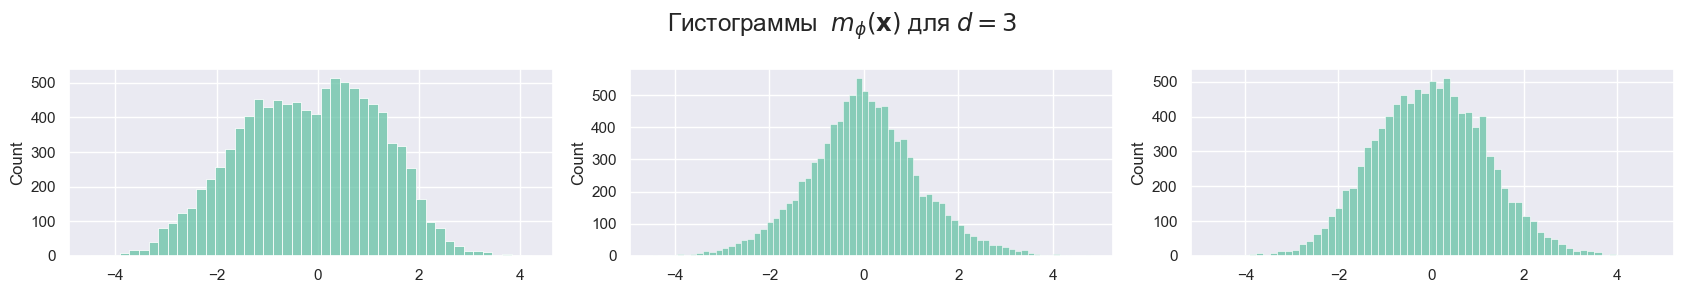

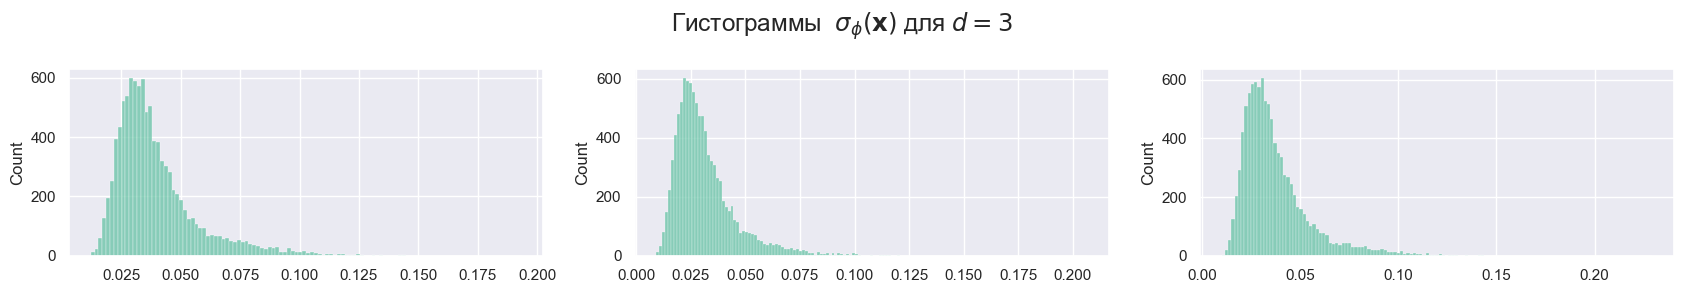

100%|███████████████████████████████████████████| 39/39 [00:07<00:00,  5.48it/s]


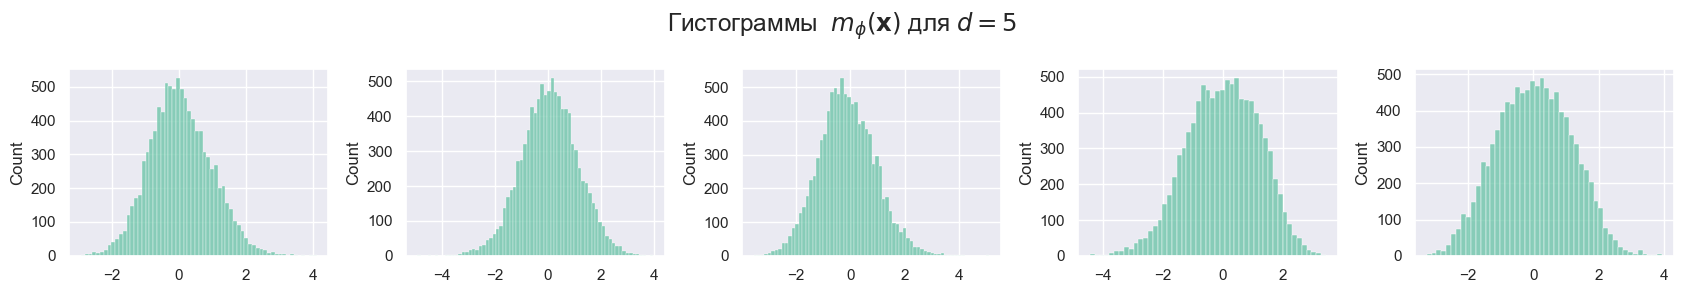

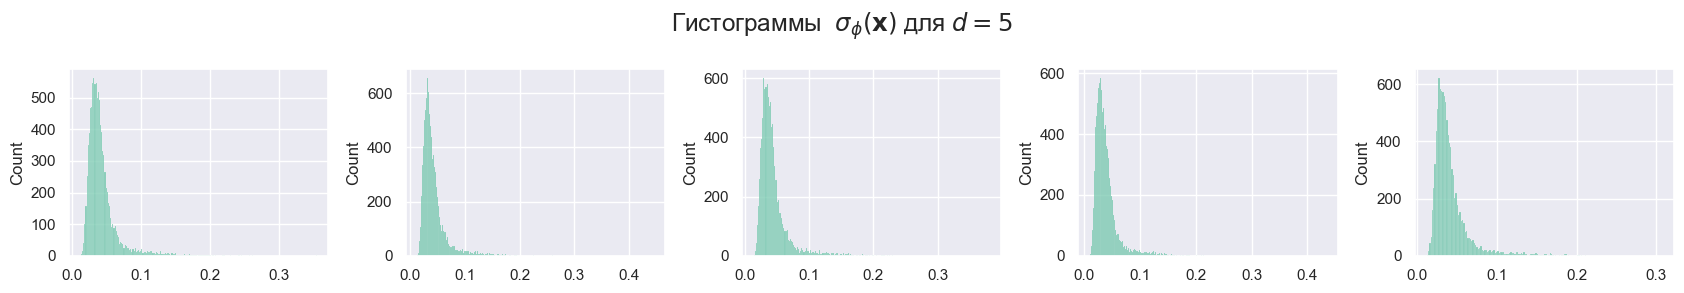

100%|███████████████████████████████████████████| 39/39 [00:07<00:00,  5.44it/s]


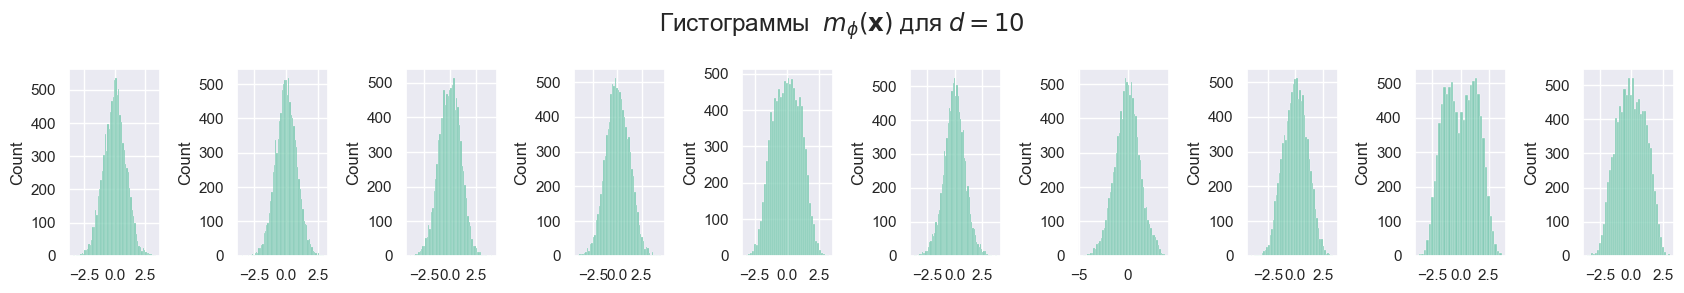

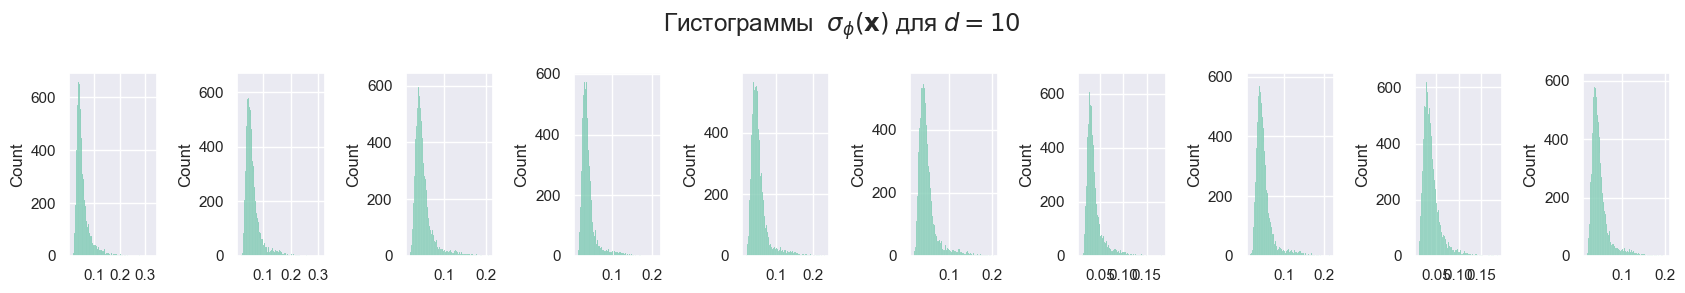

In [35]:
for Z_DIM, vae in zip([3, 5, 10], [vae_zdim3, vae_zdim5, vae_zdim10]):
    all_mus, all_sigmas = get_arrays(vae)
    for i, arr in enumerate([all_mus, all_sigmas]):
        f, ax = plt.subplots(1, Z_DIM, figsize=(17, 3))
        for j in range(Z_DIM):
            sns.histplot(arr[:, j], ax=ax[j])
        if i == 0:
            plt.suptitle(r"Гистограммы  $m_\phi(\mathbf{x})$ для $d={%d}$" % (j+1), y=.97, fontsize=17.5)
        else:
            plt.suptitle(r"Гистограммы  $\sigma_\phi(\mathbf{x})$ для $d={%d}$" % (j+1), y=.97, fontsize=17.5)

        plt.tight_layout()
        plt.show()

In [48]:
class Decoder(nn.Module):
    ''' Реализация модели сверточного декодера. '''

    def __init__(self, y_dim, p=0.1):
        '''
        y_dim -- размерность скрытого пространства
        p -- параметр dropout
        '''

        super(Decoder, self).__init__()

        # Первый несверточный слой вынесем отдельно
        self.first_layer = nn.Linear(in_features=y_dim, out_features=64*7*7)

        self.layers = nn.Sequential(
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(14, 14)),  # увеличиваем размер картинки
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(28, 28)),  # увеличиваем размер картинки
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Предсказываем вероятности белого цвета для картинки
        )

    def forward(self, x):
        x = self.first_layer(x)
        x = x.view((-1, 64, 7, 7))  # из вектора получаем трехмерный тензор
        prob_output = self.layers(x)
        return prob_output
class Encoder(nn.Module):
    ''' Реализация модели сверточного энкодера. '''

    def __init__(self, y_dim, label_dim=30, p=0.1):
        '''
        y_dim -- размерность скрытого пространства
        label_dim -- размерность метки класса
        p -- параметр dropout
        '''

        super(Encoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Flatten(),  # растягиваем тензор в вектор
            nn.Dropout(p=p)
        )

        # Полносвязные слои, отвечающие за среднее и дисперсию
        # точки в скрытом пространстве
        self.fc_output_loc = nn.Linear(in_features=3136+label_dim, out_features=y_dim)
        self.fc_output_scale = nn.Linear(in_features=3136+label_dim, out_features=y_dim)

    def forward(self, x, labels):
        hidden = self.layers(x)

        # Конкатенируем растянутый выход сверточных слоев с меткой
        hidden = torch.cat([hidden, labels], dim=1)

        # Считаем параметры распределения
        y_loc = self.fc_output_loc(hidden)
        y_scale = torch.exp(self.fc_output_scale(hidden))
        return y_loc, y_scale

In [50]:
vae_zdim30 = CVAE(z_dim=30, label_dim=30, p=0.1, use_cuda=USE_CUDA)
vae_zdim30.load_state_dict(torch.load('train_CVAE/zdim=30/vae_06_11_zdim30.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae_zdim30.train(False);

In [168]:
def get_arrays(vae):
    all_mus = []
    all_sigmas = []
    xs = []
    ys = []
    for batch in tqdm(test_loader):
        x = batch['img']
        l = batch['label']
        xs.extend(x)
        ys.extend(l)
        mu, sigma = vae.encoder(x, l)
        all_mus.extend(mu.detach().numpy())
        all_sigmas.extend(sigma.detach().numpy())
    all_mus = np.array(all_mus)
    all_sigmas = np.array(all_sigmas)
    xs = np.array(xs)
    ys = np.array(ys)
    return all_mus, all_sigmas, xs, ys

In [169]:
all_mus, all_sigmas, xs, ys = get_arrays(vae_zdim30)

100%|███████████████████████████████████████████| 39/39 [00:07<00:00,  5.29it/s]


In [170]:
all_mus.shape

(9984, 30)

In [178]:
from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [179]:
tsne = TSNE(n_components=2, random_state=42)
all_mus_2d = tsne.fit_transform(all_mus)

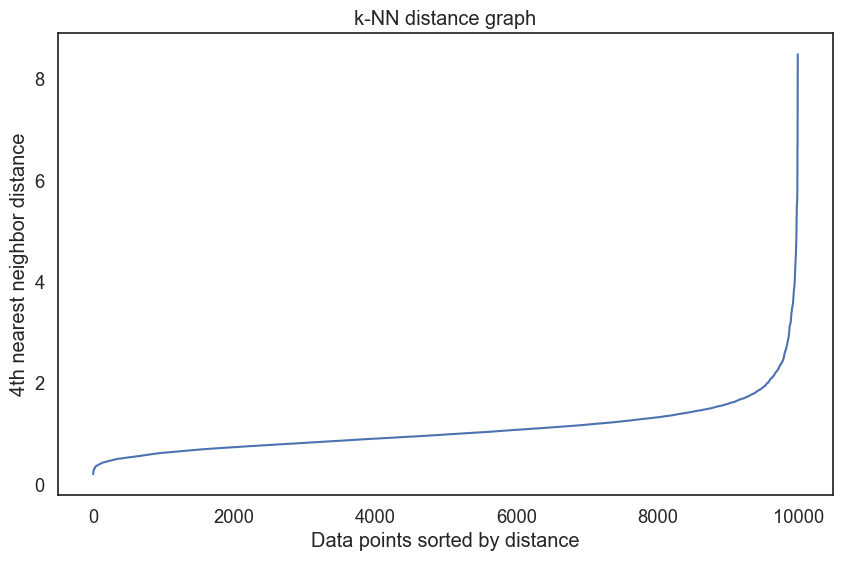

In [180]:
from sklearn.neighbors import NearestNeighbors
# Determine eps value by visualizing the k-NN distances
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(all_mus_2d)
distances, indices = neighbors.kneighbors(all_mus_2d)

# Sort and plot the distances
distances = np.sort(distances[:, 4], axis=0)  # k-NN distance
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-NN distance graph')
plt.xlabel('Data points sorted by distance')
plt.ylabel('4th nearest neighbor distance')
plt.show()

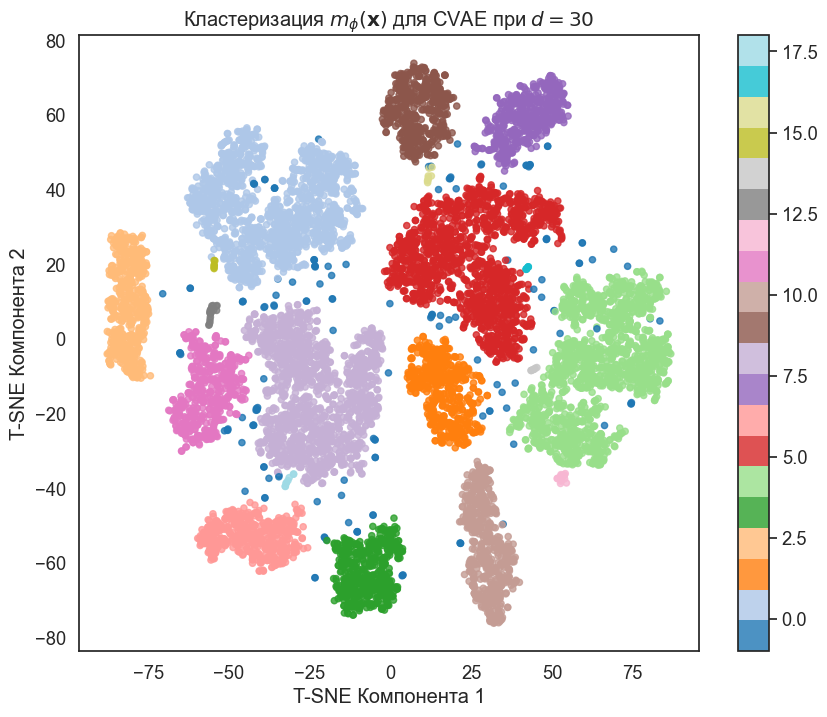

In [203]:
# Step 2: Clustering using DBSCAN
# Parameters for DBSCAN: you might need to adjust these parameters based on your data
eps = 2.5  # The maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 7 # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(all_mus_2d)

# Visualize the T-SNE reduced data and the clusters
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)
plt.figure(figsize=(10, 8))
plt.scatter(all_mus_2d[:, 0], all_mus_2d[:, 1], c=clusters, cmap='tab20', s=20, alpha=.8)
plt.colorbar()
plt.title(r'Кластеризация $m_\phi(\mathbf{x})$ для CVAE при $d=30$')
plt.xlabel('T-SNE Компонента 1')
plt.ylabel('T-SNE Компонента 2')
plt.grid(False)
plt.show()

In [190]:
def plot_img_on_ax(x, ax):
    ax.imshow(normalize(x))
    ax.axis('off')

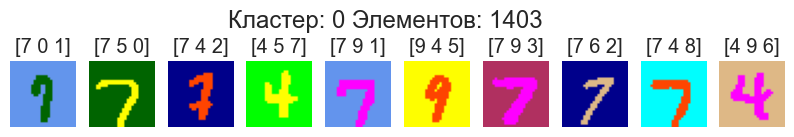

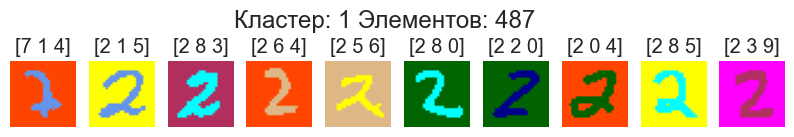

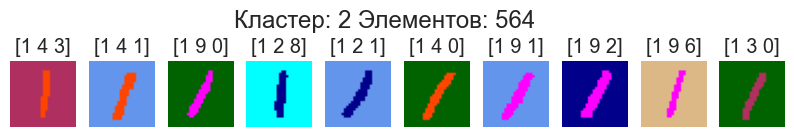

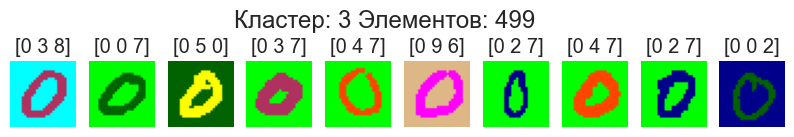

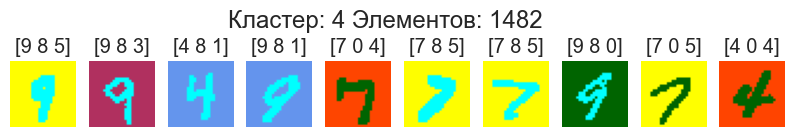

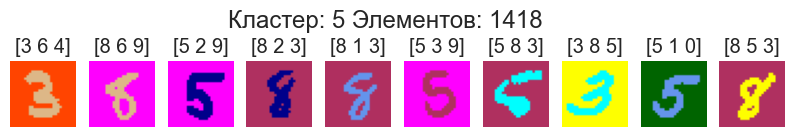

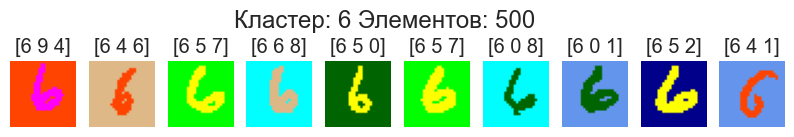

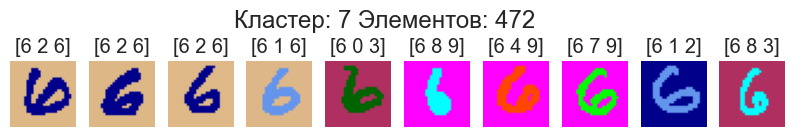

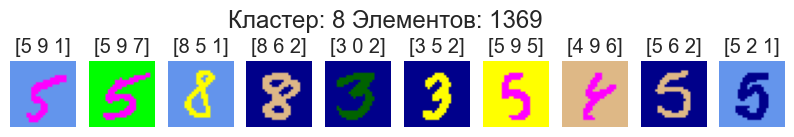

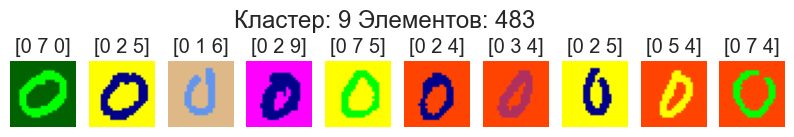

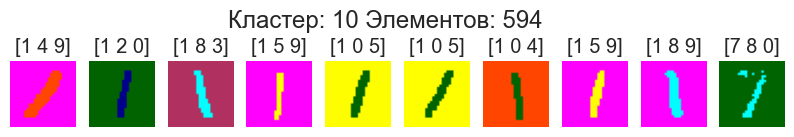

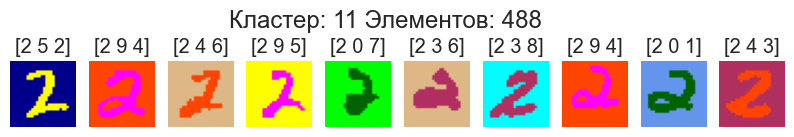

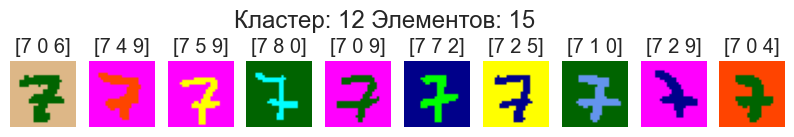

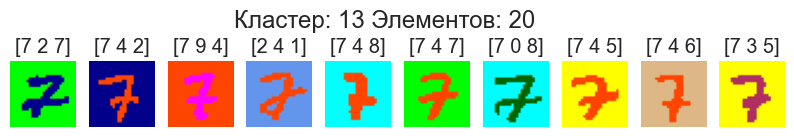

In [202]:
K = 10
# Show 5 random images from each cluster
for cluster_id in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    selected_indices = np.random.choice(cluster_indices, K, replace=False)
    
    fig, axes = plt.subplots(1, K, figsize=(K, 1))
    plt.suptitle('Кластер: '+str(cluster_id) + ' Элементов: '+str(len(cluster_indices)), y=1.34)
    for i, idx in enumerate(selected_indices):
        plot_img_on_ax(xs[idx].transpose(1,2,0), axes[i])
        axes[i].set_title(f'{ys[idx]}')
        axes[i].axis('off')
    
    plt.show()
#     break

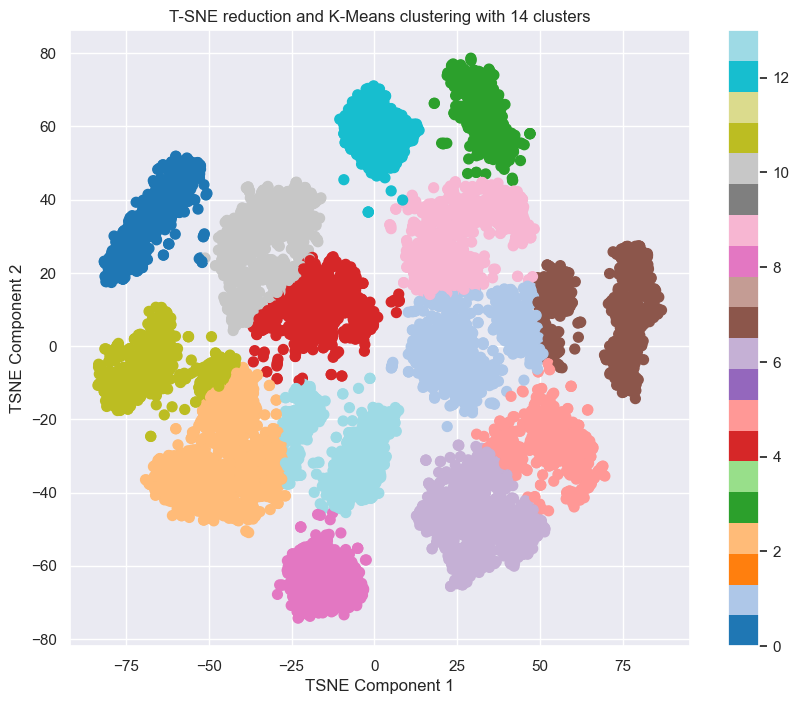

In [78]:
num_clusters = 14
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(all_mus_2d)

# Visualize the T-SNE reduced data and the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_mus_2d[:, 0], all_mus_2d[:, 1], c=clusters, cmap='tab20', s=50)
plt.colorbar(scatter)
plt.title('T-SNE reduction and K-Means clustering with 14 clusters')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()